In [1]:
import tensorflow as tf
import numpy as np

# try to obtain reproducible results given fixed generator
tf.random.set_seed(0)
np.random.seed(0)

In [3]:
import sys
!pip install tensorflow-addons

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import pandas_datareader as pdr
import yfinance as yf
yf.pdr_override()

from tensorflow.keras.models import load_model
from tensorflow.random import normal
from backend.preprocessing import *
from backend.metrics import *

In [6]:
from scipy.stats import wasserstein_distance, norm, kurtosis, skew, skewtest, kurtosistest

In [7]:
data = yf.download("^GSPC", start="2011-01-01", end="2019-12-31")
df = data['Adj Close']
log_returns = np.log(df/df.shift(1))[1:].to_numpy().reshape(-1, 1)

[*********************100%***********************]  1 of 1 completed


In [8]:
s1 = StandardScaler()
s2 = StandardScaler()
g1 = Gaussianize()
s2.fit(g1.fit_transform(s1.fit_transform(log_returns)));

In [9]:
generator = load_model('trained_generator_SP500')
rfs = 127

In [10]:
# Filter out paths with a maximum/minimum return filter_constant times that of 
# the maximum/minimum return of the original distribution
filter_constant = 2
n_samples = 1000
length = len(log_returns)

y_list = []

# I recommend you run this on a CPU colab instance, 
# since only this part is heavy. Should be done in a minute or 3

for _ in range(n_samples//100):
    noise = normal([100, 1, length + rfs - 1, 3])
    y_list.append(generator(noise).numpy().squeeze())

y = np.stack(y_list, axis=0)
del y_list

y = (y - y.mean())/y.std()
y = s2.inverse_transform(y)
y = g1.inverse_transform(np.expand_dims(y.flatten(), 1)).reshape(n_samples, length)
y = s1.inverse_transform(y);
y = y[(y.max(axis=1) <= filter_constant * log_returns.max()) & (y.min(axis=1) >= filter_constant * log_returns.min())]

In [11]:
len(y)

722

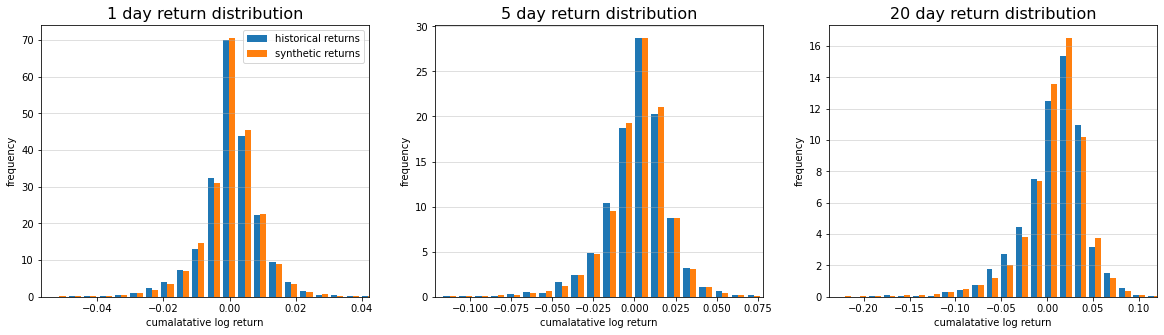

In [13]:
n_bins = 50
windows = [1, 5, 20]

fig, ax = plt.subplots(ncols=3, figsize=(20, 5))


for i in range(len(windows)):
    real_dist = rolling_window(log_returns, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    fake_dist = rolling_window(y.T, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()

    ax[i].hist(np.array([real_dist, fake_dist], dtype='object'), bins=50, density=True)
    ax[i].set_xlim(*np.quantile(fake_dist, [0.001, .999]))
    
    ax[i].set_title('{} day return distribution'.format(windows[i]), size=16)
    ax[i].yaxis.grid(True, alpha=0.5)
    ax[i].set_xlabel('cumalatative log return')
    ax[i].set_ylabel('frequency')

ax[0].legend(['historical returns', 'synthetic returns'])

plt.savefig('dist_compare.png', dpi=300)
#files.download("dist_compare.png");

In [15]:
windows = pd.Series([1, 5, 20, 100], name='window size')
EMDscores = np.zeros(len(windows))

for i in range(len(windows)):
    real_dist = rolling_window(log_returns, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    fake_dist = rolling_window(y.T, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    
    EMDscores[i] = wasserstein_distance(real_dist, fake_dist)

df_EMD = pd.DataFrame({'Earth Mover Distance' : EMDscores}, index=windows)
with open("EMD_Scores.tex", "w") as fh:
    fh.write(df_EMD.to_latex())
#files.download("EMD_Scores.tex")
df_EMD

,Earth Mover Distance
window size,
1,0.000261
5,0.000422
20,0.002294
100,0.012650


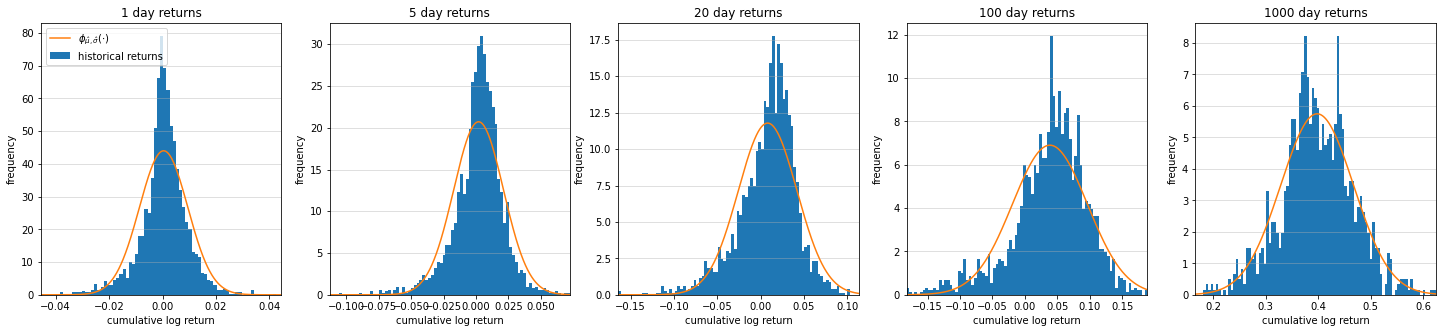

In [16]:
windows = [1, 5, 20, 100, 1000]
n_bins = 100

fig, ax = plt.subplots(ncols=len(windows), figsize=(5*len(windows),5))

for i in range(len(windows)):
    real_dist = rolling_window(log_returns, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    ax[i].hist(real_dist, bins=n_bins, density=True)
    x_range = np.linspace(*ax[i].get_xlim(), 10000)
    ax[i].plot(x_range, norm.pdf(x_range, real_dist.mean(), real_dist.std()))
    ax[i].set_xlim(*np.quantile(real_dist, [0.001, .999]))
    ax[i].set_title('{} day returns'.format(windows[i]))
    ax[i].yaxis.grid(True, alpha=0.5)
    ax[i].set_xlabel('cumulative log return')
    ax[i].set_ylabel('frequency')

ax[0].legend(['$\phi_{\hat{\mu}, \hat{\sigma}}(\cdot)$', 'historical returns'], loc='upper left')

plt.savefig('real_agg_gauss.png', dpi=300)
#files.download("real_agg_gauss.png");

MemoryError: Unable to allocate 12.2 GiB for an array with shape (1000, 2262, 722) and data type float64

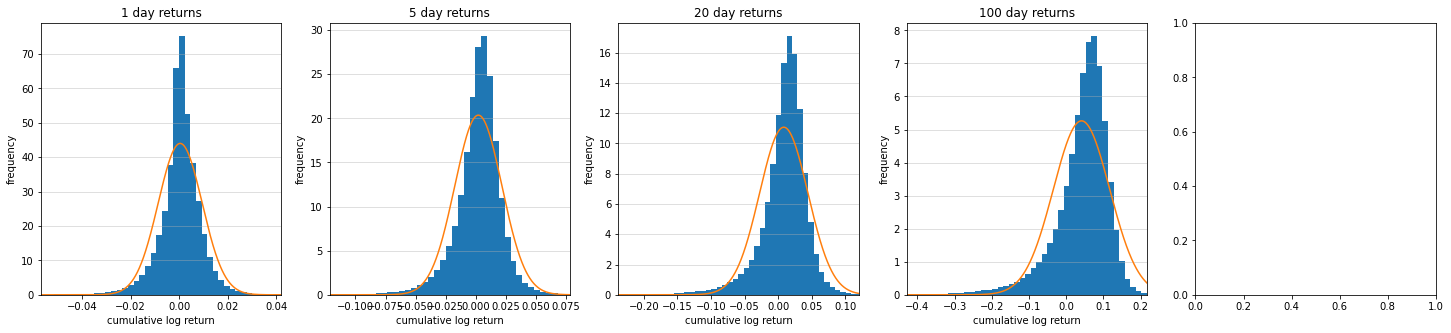

In [19]:
windows = [1, 5, 20, 100, 1000]
n_bins = 100

fig, ax = plt.subplots(ncols=len(windows), figsize=(5*len(windows),5))

for i in range(len(windows)):
    fake_dist = rolling_window(y.T, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    ax[i].hist(fake_dist, bins=n_bins, density=True)
    x_range = np.linspace(*ax[i].get_xlim(), 10000)
    ax[i].plot(x_range, norm.pdf(x_range, fake_dist.mean(), fake_dist.std()))
    ax[i].set_xlim(*np.quantile(fake_dist, [0.001, .999]))
    ax[i].set_title('{} day returns'.format(windows[i]))
    ax[i].yaxis.grid(True, alpha=0.5)
    ax[i].set_xlabel('cumulative log return')
    ax[i].set_ylabel('frequency')

ax[0].legend(['$\phi_{\hat{\mu}, \hat{\sigma}}(\cdot)$', 'synthetic returns'], loc='upper left')

plt.savefig('fake_agg_gauss.png', dpi=300)

In [20]:
windows = pd.Series([1, 5, 20, 100], name='window size')
stats_array = np.zeros((len(windows), 4))

for i in range(len(windows)):
    real_dist = rolling_window(log_returns, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).squeeze()
    stats_array[i, 0] = skew(real_dist)
    stats_array[i, 1] = skewtest(real_dist).pvalue
    stats_array[i, 2] = kurtosis(real_dist)
    stats_array[i, 3] = kurtosistest(real_dist).pvalue

stats_df = pd.DataFrame(np.round(stats_array, 3), columns=['skewness', 'skewness p-value', 'kurtosis', 'kurtosis p-value'], index=windows)

with open("stats_real.tex", "w") as fh:
    fh.write(stats_df.to_latex())
#files.download("stats_real.tex")

stats_df

,skewness,skewness p-value,kurtosis,kurtosis p-value
window size,,,,
1,-0.554,0.0,5.063,0.0
5,-0.906,0.0,4.633,0.0
20,-0.916,0.0,2.547,0.0
100,-0.784,0.0,1.237,0.0


In [21]:
windows = pd.Series([1, 5, 20, 100], name='window size')
stats_array = np.zeros((len(windows), 4))

for i in range(len(windows)):
    fake_di = rolling_window(y.T, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    stats_array[i, 0] = skew(real_dist)
    stats_array[i, 1] = skewtest(real_dist).pvalue
    stats_array[i, 2] = kurtosis(real_dist)
    stats_array[i, 3] = kurtosistest(real_dist).pvalue

stats_df = pd.DataFrame(np.round(stats_array, 3), columns=['skewness', 'skewness p-value', 'kurtosis', 'kurtosis p-value'], index=windows)

with open("stats_fake.tex", "w") as fh:
    fh.write(stats_df.to_latex())
#files.download("stats_fake.tex")

stats_df

,skewness,skewness p-value,kurtosis,kurtosis p-value
window size,,,,
1,-0.784,0.0,1.237,0.0
5,-0.784,0.0,1.237,0.0
20,-0.784,0.0,1.237,0.0
100,-0.784,0.0,1.237,0.0


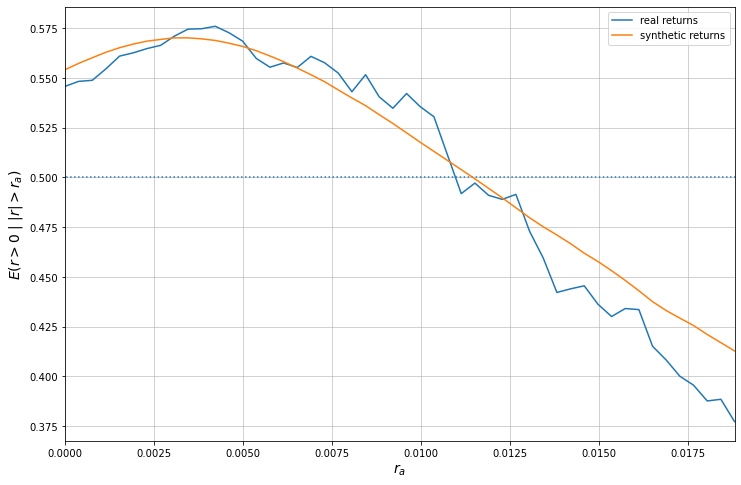

In [23]:
real_dist = log_returns.squeeze()
fake_dist = y.ravel() 

loss_assymetry = lambda dist, x: np.mean((dist[np.abs(dist) > x] >= 0))

fig, ax = plt.subplots(figsize=(12,8))
x_range = np.linspace(0, np.quantile(np.abs(real_dist), .95), 50)
ax.plot(x_range, [loss_assymetry(real_dist, x) for x in x_range], label='real returns')
ax.plot(x_range, [loss_assymetry(fake_dist, x) for x in x_range], label='synthetic returns')
ax.hlines(0.5, -1, 1, linestyles='dotted');
ax.set_xlim(0, np.quantile(np.abs(real_dist), .95))

ax.set_xlabel('$r_a$', size=14)
ax.set_ylabel('$E(r > 0$ | $|r| > r_a)$', size=14)

ax.grid(alpha=0.7)

ax.legend()

plt.savefig('gl_assymetry.png', dpi=300)
#files.download("gl_assymetry.png");

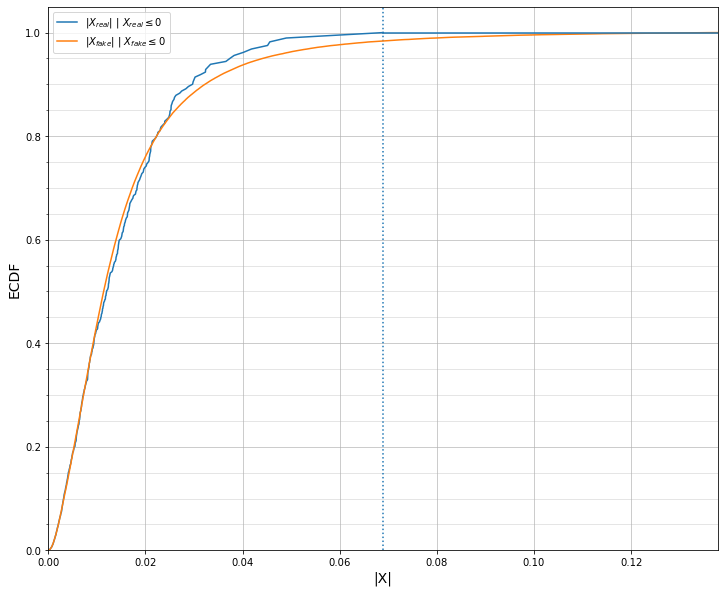

In [24]:
fig, ax = plt.subplots(figsize=(12, 10))

x_real = np.sort(abs(real_dist[real_dist <= 0]))
x_fake = np.sort(abs(fake_dist[fake_dist <= 0]))

plt.plot(x_real, x_real.cumsum()/x_real.sum())
plt.plot(x_fake, x_fake.cumsum()/x_fake.sum())

ax.grid(which='minor', alpha=0.4)
ax.grid(which='major', alpha=0.8)

ax.set_yticks(np.arange(0, 1.2, 0.2))
ax.set_yticks(np.arange(0, 1.05, .05), minor=True)

plt.xlim(0, max(x_fake))
plt.ylim(0, 1.05)


plt.plot([max(x_real), max(x_fake)], [1, 1], color='#1f77b4')

ax.vlines(max(x_real), 0, 1.5, linestyles='dotted')

ax.legend(['$|X_{real}|$ | $X_{real} \leq 0$', '$|X_{fake}|$ | $X_{fake} \leq 0$'])

ax.set_xlabel('|X|', size=14)
ax.set_ylabel('ECDF', size=14)

plt.savefig('loss_ecdf.png', dpi=300)

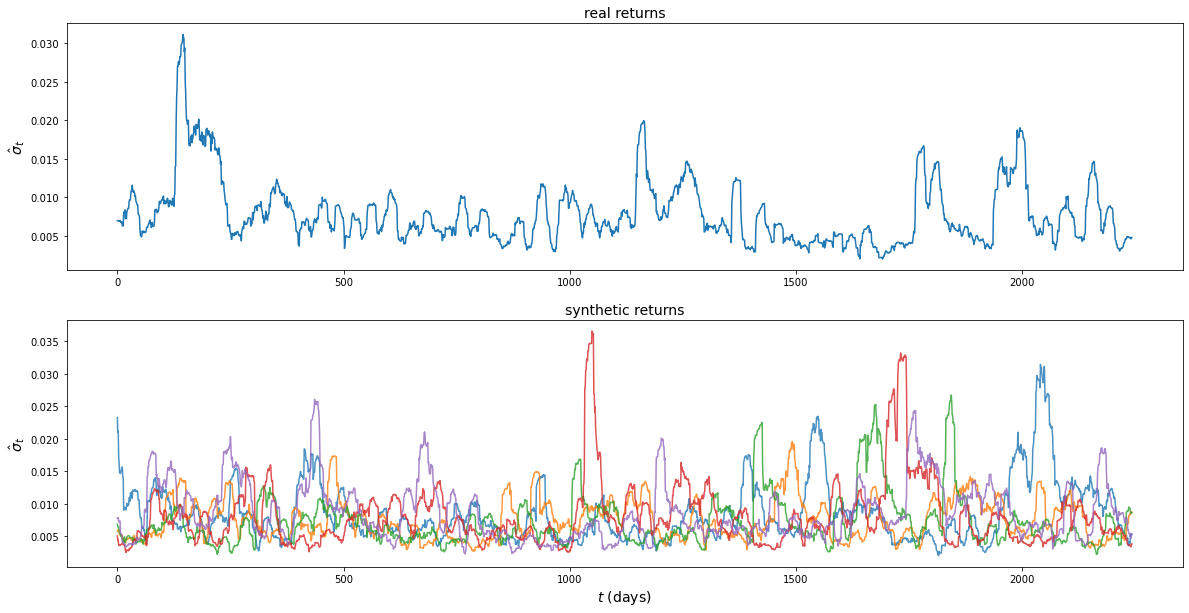

In [25]:
fig, ax = plt.subplots(figsize=(20, 10), nrows=2)
ax[0].plot(rolling_window(log_returns, 20).std(axis=0))
ax[0].set_title('real returns', size=14)
ax[1].plot(rolling_window(y[:5].T, 20).std(axis=0), alpha=0.8)
ax[1].set_title('synthetic returns', size=14)

ax[1].set_xlabel('$t$ (days)', size=14)
ax[0].set_ylabel('$\hat{\sigma}_t$', size=14)
ax[1].set_ylabel('$\hat{\sigma}_t$', size=14)

plt.savefig('intermittency.png', dpi=300)

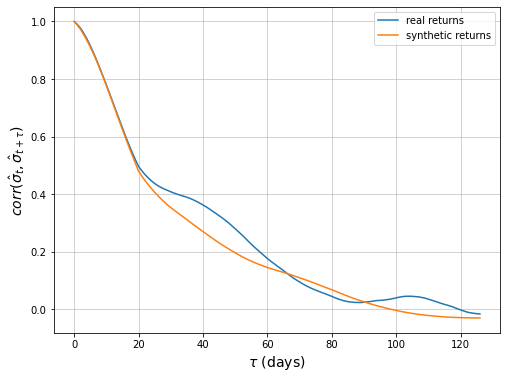

In [26]:
fig, ax = plt.subplots(figsize=(8, 6))

T = 127
fake_acf = np.zeros(T)

ax.plot(acf(rolling_window(log_returns, 20).std(axis=0), T));

for i in range(0, len(y), 50):
    fake_acf = fake_acf + acf(rolling_window(y.T[:, i:i+50], 20).std(axis=0), T).mean(axis=1)

ax.plot(fake_acf/(len(y)//50 + 1))
ax.grid(alpha=0.7)

ax.set_xlabel('$\\tau$ (days)', size=14)
ax.set_ylabel('$corr(\hat{\sigma}_t,\hat{\sigma}_{t+\\tau})$', size=14)
ax.legend(['real returns', 'synthetic returns'])

plt.savefig('vol_clust.png', dpi=300)

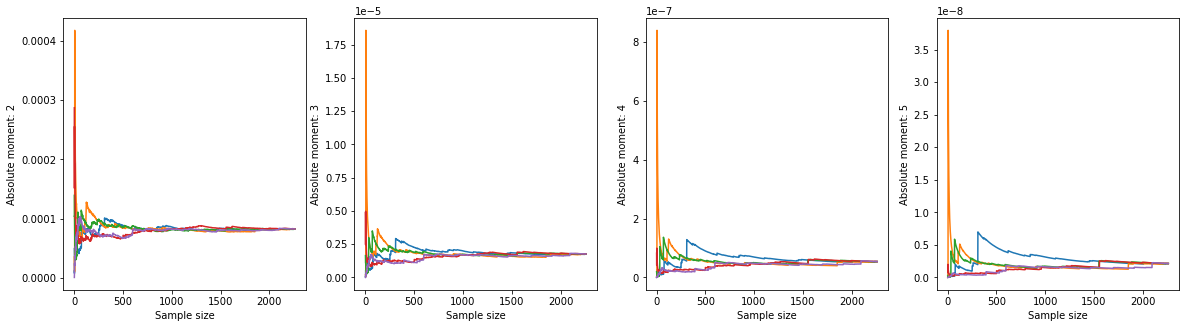

In [27]:
absolute_moments = [2, 3, 4, 5]

fig, ax = plt.subplots(figsize=(20,5), ncols=4)
x_range = range(1, len(log_returns))

for _ in range(5):
    shuffled_array = np.random.permutation(log_returns)

    for j in range(len(absolute_moments)):
        ax[j].plot(x_range, [np.mean(np.abs(shuffled_array[:i])**absolute_moments[j], axis=0) for i in x_range]);

for i in range(len(absolute_moments)):
    ax[i].set_xlabel('Sample size')
    ax[i].set_ylabel('Absolute moment: {}'.format(absolute_moments[i]))

plt.savefig('tail_idx.png', dpi=300)

C:\Users\P3002745\AppData\Local\Temp/ipykernel_4308/3020044432.py:10: RuntimeWarning: underflow encountered in power
  paths = np.array([np.mean(np.abs(shuffled_array[:i, :50])**absolute_moments[j], axis=0) for i in x_range])


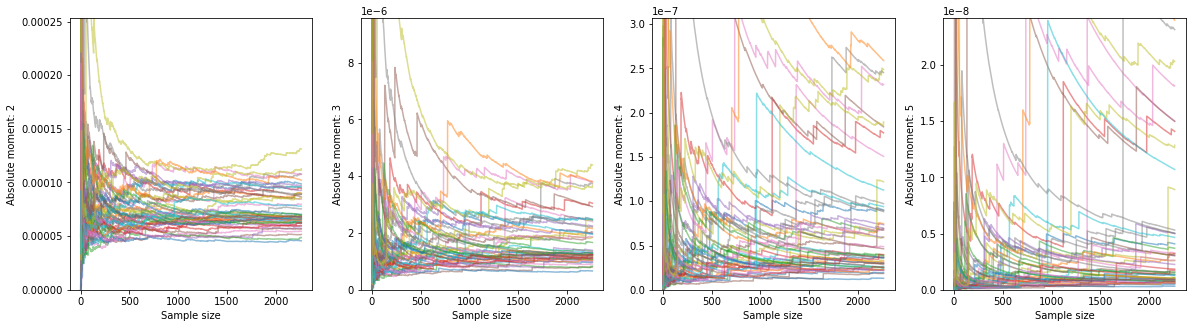

In [28]:
absolute_moments = [2, 3, 4, 5]

fig, ax = plt.subplots(figsize=(5*len(absolute_moments), 5), ncols=len(absolute_moments))
x_range = range(1, len(log_returns))

# shuffle along first index, so tranpose
shuffled_array = np.random.permutation(y.T)

for j in range(len(absolute_moments)):
    paths = np.array([np.mean(np.abs(shuffled_array[:i, :50])**absolute_moments[j], axis=0) for i in x_range])
    ax[j].plot(x_range, paths, alpha=0.5)
    ax[j].set_ylim(0, np.quantile(paths.max(axis=0), .85))
    ax[j].set_xlabel('Sample size')
    ax[j].set_ylabel('Absolute moment: {}'.format(absolute_moments[j]))

plt.savefig('tail_idx_fake.png', dpi=300)

MemoryError: Unable to allocate 1.22 GiB for an array with shape (100, 2262, 722) and data type float64

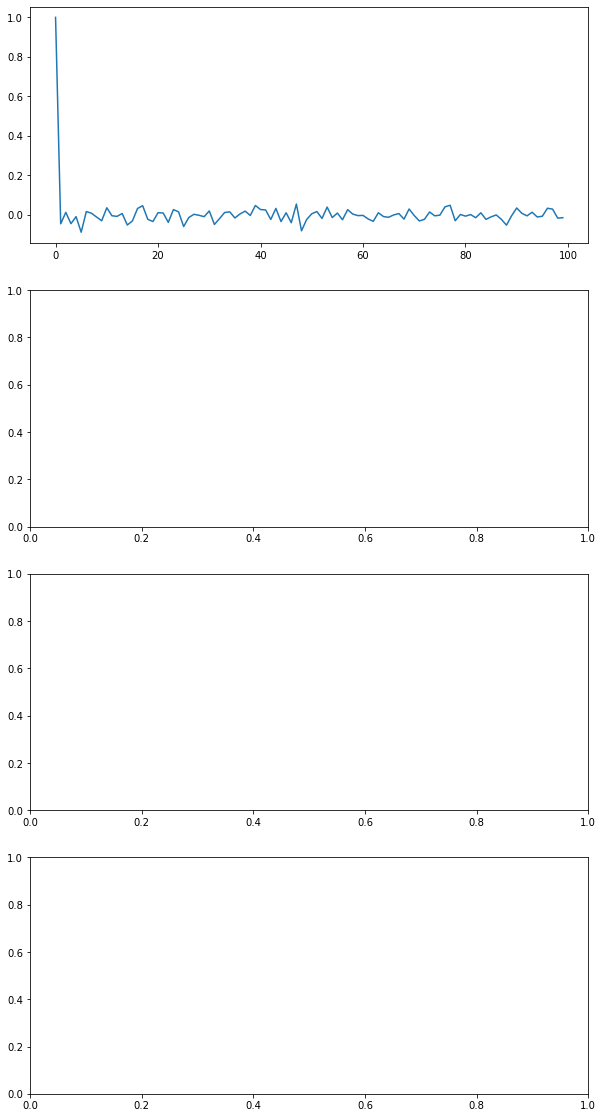

In [29]:
fig, axs = plt.subplots(nrows=4, figsize=(10, 20))

axs[0].plot(acf(log_returns, 100))
axs[0].plot(acf(y.T, 100).mean(axis=1))
axs[0].set_ylim(-0.1, 0.1)
axs[0].set_ylabel('$corr(r_t, r_{t+\\tau})$')

axs[1].plot(acf(log_returns**2, 100))
axs[1].set_ylim(-0.05, 0.5)
axs[1].set_ylabel('$corr(r_t^2, r_{t+\\tau}^2)$')
axs[1].plot(acf(y.T**2, 100).mean(axis=1))

axs[2].plot(acf(abs(log_returns), 100, le=False))
axs[2].plot(acf(abs(y.T), 100, le=False).mean(axis=1))
axs[1].set_ylim(-0.05, 0.5)
axs[2].set_ylabel('$corr(|r_t|, |r_{t+\\tau}|)$')

axs[3].plot(acf(log_returns, 100, le=True))
axs[3].plot(acf(y.T, 100, le=True).mean(axis=1))
axs[3].set_ylim(-0.2, 0.1)
axs[3].set_ylabel('$corr(r_t, r_{t+\\tau}^2)$')

for ax in axs: ax.grid(True)
plt.setp(axs, xlabel='$\\tau$ (days)')
plt.tight_layout()

plt.savefig('acf_sp500.png', dpi=300)

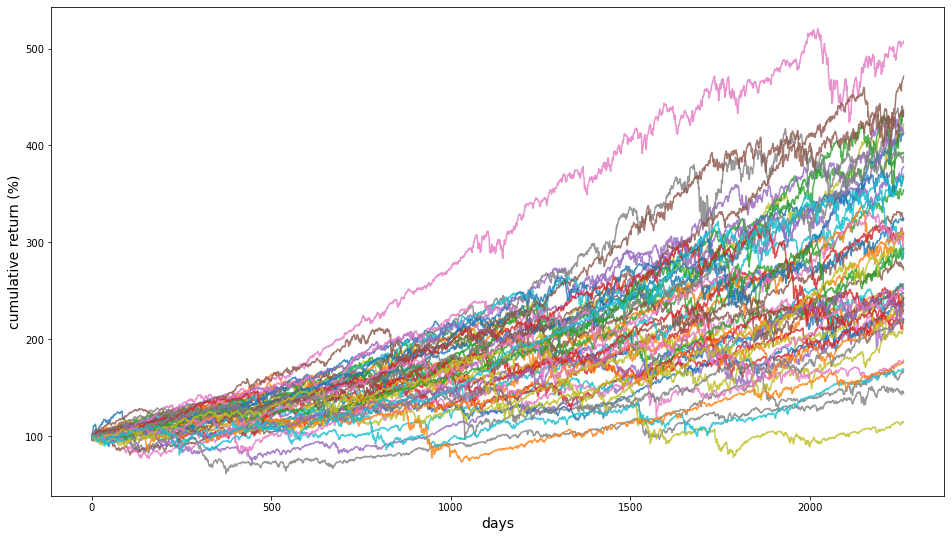

In [30]:
fig, ax = plt.subplots(figsize=(16,9))

ax.plot(np.exp(y.T[:,:50]).cumprod(axis=0)*100, alpha=0.8)
ax.set_xlabel('days', size=14)
ax.set_ylabel('cumulative return (%)', size=14)

plt.savefig('sp500_paths.png', dpi=300)